In [4]:
! pip install -q tensor-sensor

In [5]:
import tsensor
tsensor.__version__

'0.1a27'

### NumPy

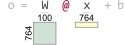

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 764 is different from 100)
Cause: @ on tensor operand W w/shape (764, 100) and operand x w/shape (764,)

In [11]:
import numpy as np

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = np.random.rand(d,n_neurons)
b = np.random.rand(n_neurons)
X = np.random.rand(n,d)
with tsensor.explain():
    for x in X:
        o = W @ x + b

### PyTorch

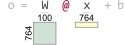

RuntimeError: size mismatch, get 764, 764x100,764
Cause: @ on tensor operand W w/shape [764, 100] and operand x w/shape [764]

In [12]:
import torch

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = torch.rand(d,n_neurons)
b = torch.rand(n_neurons)
X = torch.rand(n,d)
with tsensor.explain():
    for x in X:
        o = W @ x + b

### TensorFlow

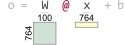

InvalidArgumentError: In[1] is not a matrix. Instead it has shape [764] [Op:MatMul]
Cause: @ on tensor operand W w/shape (764, 100) and operand x w/shape (764,)

In [20]:
import tensorflow as tf

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = tf.random.uniform((d,n_neurons))
b = tf.random.uniform((n_neurons,))
X = tf.random.uniform((n,d))
with tsensor.explain():
    for x in X:
        o = W @ x + b